In [1]:
%matplotlib inline

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec
# from rootpy.io import root_open
from sklearn.neighbors import BallTree, DistanceMetric

mpl.rc('font', size=15)

In [2]:
# convert ROOT histogram into numpy arrays
def convert_to_array(hist):
    n = hist.GetNbinsX()   # number of bins
    axis = hist.GetXaxis() 
    
    # output
    bins = np.empty(n+1)
    entries = np.empty(n)
    for i in xrange(n):
        entries[i] = hist.GetBinContent(i+1)
        bins[i] = axis.GetBinLowEdge(i+1)
    bins[i+1] = axis.GetBinUpEdge(n)
    
    return entries, bins

In [3]:
# convert ROOT histogram into numpy arrays
def convert_to_array2(hist2d):
    n_x = hist2d.GetNbinsX()   # number of bins x
    n_y = hist2d.GetNbinsY()   # number of bins y
    
    axis_x = hist2d.GetXaxis() 
    axis_y = hist2d.GetYaxis()
    
    # output
    bins_x = np.empty(n_x+1)
    bins_y = np.empty(n_y+1)
    entries = np.empty((n_x, n_y))
    for i in xrange(n_x):
        for j in xrange(n_y):
            entries[i, j] =  hist2d.GetBinContent(i+1, j+1)
    
    for i in xrange(n_x):
        bins_x[i] = axis_x.GetBinLowEdge(i+1)
    bins_x[n_x] = axis_x.GetBinUpEdge(n_x)
    
    for i in xrange(n_y):
        bins_y[i] = axis_y.GetBinLowEdge(i+1)
    bins_y[n_y] = axis_y.GetBinUpEdge(n_y)
    
    return entries, bins_x, bins_y

# Import data 

In [4]:
# import data
catalog_dir = "/home/chris/project/bao/correlation/catalog/"
random_filename = catalog_dir+"boss/randoms_DR9_CMASS_North_DC.dat"
data_filename = catalog_dir+"boss/galaxies_DR9_CMASS_North_DC.dat"

ra, dec, r, w = np.genfromtxt(random_filename, skip_header=1, unpack=True)
rand_cat = np.array([dec, ra, r, w]).T

ra, dec, r, w = np.genfromtxt(data_filename, skip_header=1, unpack=True)
data_cat = np.array([dec, ra, r, w]).T

# Construct DR
## Defing binning

In [5]:
# define constant
degtorad = np.pi/180.
radtodeg = 180./np.pi

n_rand = rand_cat.shape[0]
n_data = data_cat.shape[0]

# define boundaries
s_max = 200.   # Mpc/h
dec_min = np.minimum(rand_cat[:,0].min(), data_cat[:,0].min())
dec_max = np.minimum(rand_cat[:,0].max(), data_cat[:,0].max())
ra_min = np.minimum(rand_cat[:,1].min(), data_cat[:,1].min())
ra_max = np.maximum(rand_cat[:,1].max(), data_cat[:,1].max())
r_min = np.minimum(rand_cat[:,2].min(), data_cat[:,2].min())
r_max = np.maximum(rand_cat[:,2].max(), data_cat[:,2].max())
theta_max = np.arccos(1-0.5*s_max**2/r_min**2)

# define binnings
binwidth_ra = 0.25  # deg
binwidth_dec = 0.25  # deg
binwidth_theta = 0.1  # deg
binwidth_r = 1.00   # Mpc/h
binwidth_s = 4.0   # Mpc/h
nbin_ra = int(np.ceil((ra_max-ra_min)/binwidth_ra))
nbin_dec = int(np.ceil((dec_max-dec_min)/binwidth_dec))
nbin_theta = int(np.ceil(theta_max/(degtorad*binwidth_theta)))
nbin_r = int(np.ceil((r_max-r_min)/binwidth_r))
nbin_s = int(np.ceil((s_max)/binwidth_s))

## Construct P(r)

In [6]:
# construct RR(s)
# construct P(r)
r_hist, bins_r = np.histogram(rand_cat[:,2], nbin_r)
r_hist = 1.*r_hist/n_rand

## Construct g(theta, r)

In [24]:
import numpy

In [26]:
def histogram2points(hist, bins_x, bins_y, exclude_zeros=True):
    ''' Convert 2-d histogram into data points with weight.
        Take bincenters as data points.
        Parameters:
        + hist:  2-d numpy array
            The values of of the histogram.
            Dimension must be [Nx, Ny], the number of bins in X and Y
        + bins_x:  numpy array
            Binedges in X, length must be Nx+1
        + bins_y:  numpy array
            Binedges in Y, length must be Nx+1
        + exclude_zeros: bool (default = True)
            Excluded zeros bins
        Outputs:
        + data: 2-d numpy array
            Array of data points with weight. Format [X,Y,Weight]
        '''
    center_x = 0.5*(bins_x[:-1]+bins_x[1:])
    center_y = 0.5*(bins_y[:-1]+bins_y[1:])
    grid_x, grid_y = numpy.meshgrid(center_x, center_y)
    grid_x = grid_x.flatten()
    grid_y = grid_y.flatten()
    hist = hist.T.flatten()

    # Create data array with non-zero bins
    data = numpy.array([grid_x, grid_y, hist]).T
    if exclude_zeros:
        return data[hist > 0]
    return data

In [42]:
temp_angular = numpy.histogram2d(degtorad*rand_cat[:, 0], degtorad*rand_cat[:, 1], (nbin_dec, nbin_ra))
angular_distr = histogram2points(*temp_angular)

# create a BallTree and compute g(theta, r) up to self.__theta_max
arc_tree2 = BallTree(angular_distr[:, :2], leaf_size=1,
                     metric='haversine')
r_theta_test = numpy.zeros((nbin_theta, nbin_r))

In [7]:
# construct R(ra, dec)
angular_counts, ra_edges, dec_edges = np.histogram2d(rand_cat[:,1], rand_cat[:,0], (nbin_ra, nbin_dec))
angular_counts = angular_counts.T

# generate data set with weight
ra_centers = 0.5*(ra_edges[:-1]+ra_edges[1:])
dec_centers = 0.5*(dec_edges[:-1]+dec_edges[1:])
ra_grid, dec_grid = np.meshgrid(ra_centers, dec_centers)
ra_grid = ra_grid.flatten()
dec_grid = dec_grid.flatten()
angular_counts = angular_counts.flatten()

data = np.array([degtorad*dec_grid, degtorad*ra_grid, angular_counts]).T
data = data[angular_counts>0]

# create Tree
arc_tree = BallTree(data[:,:2], leaf_size=1, metric='haversine')

In [46]:
r_theta_test = numpy.zeros((nbin_theta, nbin_r))
for i, point in enumerate(data_cat):
    if i % 10000 is 0:
        print(i)
    index, theta = arc_tree2.query_radius(degtorad*point[:2].reshape(1, -1),
                                         r=theta_max,
                                         return_distance=True)
    temp_r = numpy.ones_like(theta[0])*point[2]
    temp_weight = angular_distr[:,2][index[0]]
    h2, bins_theta, bins_r = numpy.histogram2d(
        theta[0], temp_r,
        bins=(bins_theta, bins_r),
        weights=temp_weight)
    r_theta_test += h2

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000


In [43]:
r_theta_test = numpy.zeros((nbin_theta, nbin_r))
for i, point in enumerate(data_cat):
    if i % 10000 is 0:
        print(i)
    index, theta = arc_tree.query_radius(degtorad*point[:2].reshape(1, -1),
                                         r=theta_max,
                                         return_distance=True)
    temp_r = numpy.ones_like(theta[0])*point[2]
    temp_weight = data[:,2][index[0]]
    h, bins_theta, bins_r = numpy.histogram2d(
        theta[0], temp_r,
        bins=(bins_theta, bins_r),
        weights=temp_weight)
    r_theta_test += h

0


In [38]:
# compute g(theta, theta)
bins_theta = np.linspace(0., theta_max, nbin_theta+1)
r_theta_hist = np.zeros((nbin_theta, nbin_r))
for i, point in enumerate(data_cat):
    if i%10000 is 0:
        print i
    index, theta = arc_tree.query_radius(degtorad*point[:2].reshape(1,-1), r=theta_max, return_distance=True)
    index = index[0]
    theta = theta[0]
    rtemp = np.ones_like(theta)*point[2]
    temp_hist, _, _ = np.histogram2d(theta, rtemp, bins=(bins_theta, bins_r), weights = data[:,2][index])
    r_theta_hist += temp_hist
    break

0


In [ ]:
from rootpy.io import root_open

root_filename = "/home/chris/project/bao/correlation/tpcf/test/r_theta.root"

#import ROOT histogram and convert to NumPy array
rootfile = root_open(root_filename, "read")
r_theta_root, bins_theta_root, bins_r_root = convert_to_array2(rootfile.Get("r_theta_hist"))

In [ ]:
r_theta_root[:,1:-1]

In [ ]:
r_theta_hist

## Construct DR

In [48]:
def separation(r1, r2, theta):
    return np.sqrt(r1**2+r2**2-2*r1*r2*np.cos(theta))

In [49]:
r_centers = 0.5*(bins_r[1:]+bins_r[:-1])
theta_centers = 0.5*(bins_theta[1:]+bins_theta[:-1])

In [50]:
w = r_theta_test.flatten()

a, b = np.meshgrid(r_centers, theta_centers)
a = a.flatten()
b = b.flatten()

c = np.array([a,b,w]).T
c = c[w!=0]

In [51]:
bins_s = np.linspace(0., s_max, nbin_s+1)
dr = np.zeros(nbin_s)
for i, rtemp in enumerate(r_centers[r_hist!=0]):
    if i%100 is 0:
        print i
    s = separation(rtemp, c[:,0], c[:,1])
    temp_w = r_hist[i]*c[:,2]
    temp_hist, _ = np.histogram(s, bins_s, weights = temp_w)
    dr += temp_hist    

0
100
200
300
400
500
600


In [52]:
# normalize
# unweighted
norm_dr = n_rand*n_data
dr_norm = dr/norm_dr

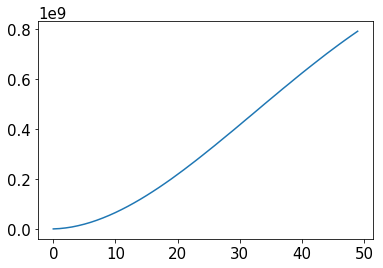

In [56]:
plt.plot(dr)

In [57]:
from rootpy.io import root_open

root_filename = "/home/chris/project/bao/correlation/tpcf/out/BOSS_North.root"

#import ROOT histogram and convert to NumPy array
rootfile = root_open(root_filename, "read")
dr_root, bins_root = convert_to_array(rootfile.Get("Unweighted").Get("data_rand_uw"))
rr_root, bins_root = convert_to_array(rootfile.Get("Unweighted").Get("rand_rand_uw"))
dd_root, bins_root = convert_to_array(rootfile.Get("Unweighted").Get("data_data_uw"))

Welcome to JupyROOT 6.08/06


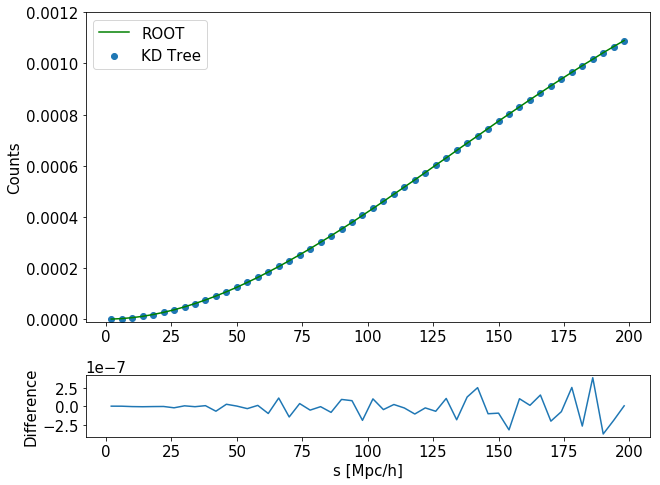

In [58]:
fig = plt.figure(figsize=(12,7))
gs  = gridspec.GridSpec(2, 2, width_ratios=[10,3], height_ratios=[10,2])
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[2], sharex = ax1)

# plot two histograms on top of each other
x = 0.5*(bins_s[:-1]+bins_s[1:])
ax1.scatter(x, dr_norm, label = 'KD Tree')
ax1.plot(x, dr_root, color = 'g', label = 'ROOT')
ax1.set(ylim = [-0.00001,0.0012],
        ylabel='Counts')

ax2.plot(x, dr_norm-dr_root)
ax2.set(xlabel='s [Mpc/h]',
        ylabel='Difference')

ax1.legend()
fig.tight_layout()

## Save result

In [59]:
np.savez("dr", DR=dr_norm, BINS=bins_s)

In [60]:
dd_norm = np.load("dd.npz")['DD']
rr_norm = np.load("rr.npz")['RR']

IOError: [Errno 2] No such file or directory: 'dd.npz'

In [61]:
tpcf = x**2*(dd_norm-2*dr_norm+rr_norm)/rr_norm
tpcf_root = x**2*(dd_root-2*dr_root+rr_root)/rr_root

fig = plt.figure(figsize=(12,12))

plt.plot(bins_s[1:], tpcf)
plt.plot(bins_s[1:], tpcf_root)

plt.xlim()

NameError: name 'dd_norm' is not defined